In [1]:
# Import required libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # For classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.fftpack import fft2, ifft2

In [2]:
# Set the path for the dataset (GALLERY)
GALLERY = os.path.join(os.getcwd(), 'att_faces')

# Initialize lists to hold images and labels
images = []
labels = []

In [3]:
# Load images and labels from GALLERY
for folder in os.listdir(GALLERY):
    folder_path = os.path.join(GALLERY, folder)  # Path to the individual folder
    if os.path.isdir(folder_path):  # Check if it's a valid directory
        for img_filename in os.listdir(folder_path):  # Iterate over image files
            img_path = os.path.join(folder_path, img_filename)  # Full path to image
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            labels.append(int(folder.split("s")[1]))  # Extract label from folder name
            images.append(np.array(img))  # Store image as a NumPy array

# Convert lists to NumPy arrays
images = np.array(images)  # Shape: (num_images, height, width)
labels = np.array(labels)  # Shape: (num_images,)

In [4]:
# Flatten images for PCA (convert 2D images to 1D vectors)
num_images, height, width = images.shape
images_flattened = images.reshape(num_images, height * width)  # Shape

In [5]:
# FFT (Fast Fourier Transform) - Apply FFT to each image
images_fft = np.zeros_like(images_flattened)
for i in range(num_images):
    img = images[i]
    fft_result = fft2(img)
    images_fft[i] = np.abs(fft_result).flatten()  # Store the magnitude of FFT for feature extraction

In [6]:
# Normalize the data by subtracting the mean (mean-centering)
images_mean = np.mean(images_flattened, axis=0)  # Compute mean of all images
images_normalized = images_flattened - images_mean  # Subtract the mean

In [7]:
# Compute the covariance matrix
covariance_matrix = np.cov(images_normalized, rowvar=False)

In [8]:
# Singular Value Decomposition (SVD) for Eigenfaces
U, S, Vt = np.linalg.svd(covariance_matrix)
eigenfaces = Vt.T  # Eigenfaces are the eigenvectors of the covariance matrix

In [9]:
# Apply PCA to find principal components
pca = PCA()
pca.fit(images_normalized)

PCA()

In [10]:
# Explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

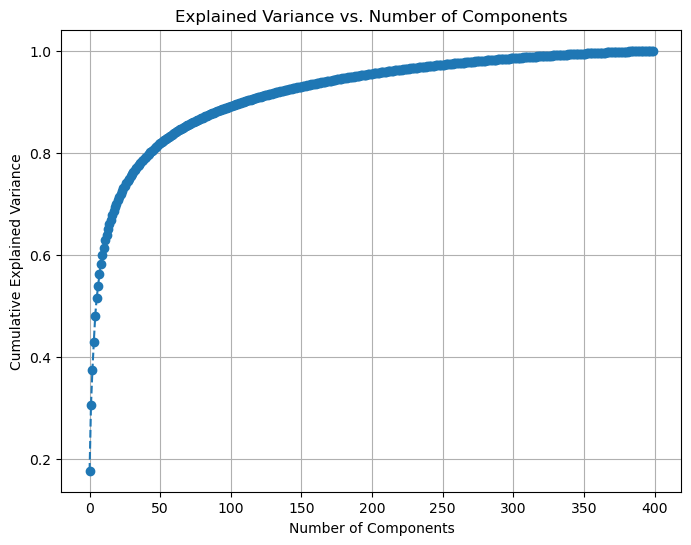

In [11]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

In [12]:
# Function to reconstruct faces with a specified number of components
def reconstruct_faces(n_components):
    """
    Reconstructs faces using a specified number of principal components.
    Args:
        n_components (int): Number of components to use for reconstruction.
    Returns:
        np.array: Reconstructed images.
    """
    pca_reduced = PCA(n_components=n_components)  # Fit PCA with reduced components
    reduced_data = pca_reduced.fit_transform(images_normalized)  # Project to lower dimension
    reconstructed = pca_reduced.inverse_transform(reduced_data)  # Project back to original space
    return reconstructed + images_mean  # Add the mean back to reconstruct images

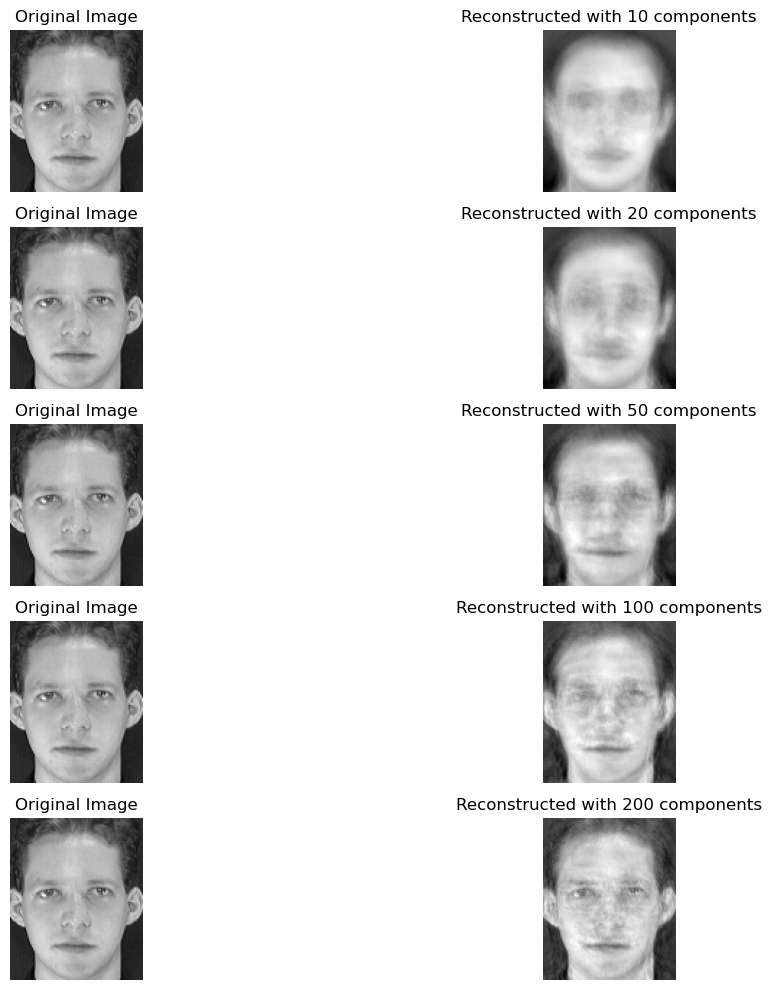

In [13]:
# Visualize original vs reconstructed images for various numbers of components
components_to_try = [10, 20, 50, 100, 200]
plt.figure(figsize=(15, len(components_to_try) * 2))
for i, n_components in enumerate(components_to_try):
    reconstructed_images = reconstruct_faces(n_components).reshape(num_images, height, width)
    
    # Original image (first image in the dataset)
    plt.subplot(len(components_to_try), 2, 2 * i + 1)
    plt.imshow(images[0], cmap='gray')  # Display the original image
    plt.title('Original Image')
    plt.axis('off')
    
    # Reconstructed image (first image)
    plt.subplot(len(components_to_try), 2, 2 * i + 2)
    plt.imshow(reconstructed_images[0], cmap='gray')  # Display reconstructed image
    plt.title(f'Reconstructed with {n_components} components')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

In [15]:
# Train a classifier (Support Vector Machine)
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [16]:
# Predict on test set
y_pred = svm.predict(X_test)

In [17]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

Classification Accuracy: 98.75%
